In [ ]:
import tables
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scikits.bootstrap as boot
from pathlib import Path
h5_file_path = Path("./self-assembly_data/")
import h5py
SMALL_PLOT_SIZE_MM = (30, 30)
SMALL_PLOT_SIZE_IN = (SMALL_PLOT_SIZE_MM[0] / 25.4, SMALL_PLOT_SIZE_MM[1] / 25.4)
plt.style.use("small-matplotlib.style")

import seaborn as sns
# sns.set_context("talk",rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":24})

sns.set_style("whitegrid",{"grid.color": '.9', 'grid.linestyle': '--','axes.edgecolor': '.6', \
                           'xtick.bottom': True,'ytick.left': True})

In [2]:
def bcierr(x):
    try:
        return boot.ci(x, method='abc', output='errorbar')
    except:
        return np.full((2, x.shape[0]), np.nan)

def calc_cols(arr):
    growthrate_array = arr.cols.invtimes_array[:]
    
    #growthrate_array[growthrate_array <= 1.01 * 1/arr.attrs['maxtime']] = np.nan
    
    growthrate_array *= arr.attrs['targetsize']

    speed = growthrate_array.mean(axis=1)
    speed_err = np.apply_along_axis(bcierr, 1, growthrate_array)[:,:,0].T

    nsims = arr.attrs['nsims']
    repscut = (arr.attrs['targetsize'] / 6 - 6)/2
    cutcol = int(3 + repscut*2)


    pd = np.logspace(-8, 0, 1000)
    plow = np.vectorize(lambda k: pd[np.flatnonzero(scipy.stats.binom.sf(k, nsims*repscut, pd) >= 0.05)[0]])
    phigh = np.vectorize(lambda k: pd[np.flatnonzero(scipy.stats.binom.sf(k, nsims*repscut, pd) >= 0.95)[0]])

    mmc = arr.col('mismatch_locs_array')[:,:,:,:cutcol].astype(bool).sum(axis=3).sum(axis=2).sum(axis=1)/2
    mmm = arr.col('mismatch_locs_array')[:,:,:,:cutcol].astype(bool).sum(axis=3).sum(axis=2).mean(axis=1)/2 / repscut

    mmerrs = [np.maximum(mmm-plow(mmc),0), phigh(mmc)-mmm]
    
    growthrate_array.sort(axis=1)
    p5 = np.quantile(growthrate_array, [0.5], axis=1)[0,:]
    qr = np.abs(np.quantile(growthrate_array, [0.05, 0.95], axis=1) - p5)

    
    return {
        'speed': speed,
        'speed_err': speed_err,
        'speed_median': p5,
        'speed_90range': qr,
        'error_rate': mmm,
        'error_rate_err': mmerrs,
    }


In [3]:
sweep_melttime = tables.open_file(h5_file_path / '2023-11-21_sims-sweep-melt-time-big.h5')

sweep_noinst_growtemp = tables.open_file(
    h5_file_path / "2023-11-24_sims-sweep-growth-temperature-big-nofilter.h5"
)

In [4]:
ds = "stall_error"
sgt = sweep_noinst_growtemp.get_node(f'/{ds}/results')
ccm = calc_cols(arr=sgt)
cci = calc_cols(sweep_melttime.get_node(f'/{ds}/results_8.4'))


In [5]:
growgse = np.arange(8.75, 10.0, 0.05)

In [6]:
import matplotlib.transforms as mtransforms

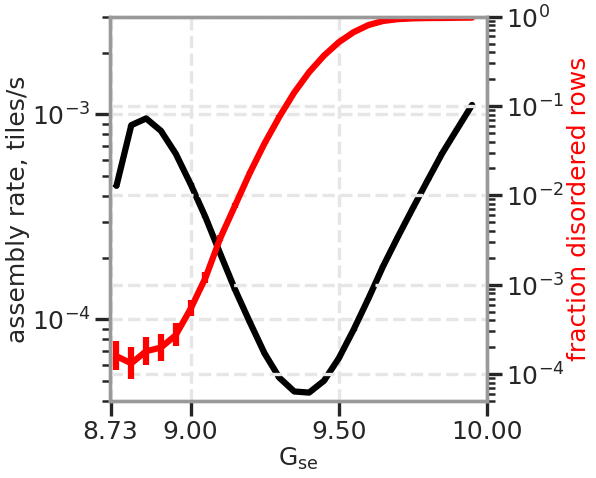

In [8]:

fig, ax = plt.subplots(figsize=(50/25.4,40/25.4), constrained_layout=True)
ax2 = ax.twinx()

r = "stall_error"
ax.errorbar(growgse, ccm['speed'], ccm['speed_err'], color='black')
ax2.errorbar(growgse, ccm['error_rate'], ccm['error_rate_err'], color='red')

ax.set_yscale('log')
ax.set_xlabel(r"$G_\text{se}$")
ax.set_ylabel("assembly rate, tiles/s")
ax.set_ylim(4e-5, 3e-3)
# ax.set_xlim(0, 400)

ax.set_xticks([9, 9.5, 10] + [8.73])
ax.set_xlim(8.727, 10.00)

ax2.set_yscale('log')
ax2.set_ylabel('fraction disordered rows', color='red')
ax2.set_ylim(5e-5, 1.0)

fig.savefig("figure-plots/extfig4-growthtemp-sweep.svg")


In [9]:
np.exp(-2*8.73)

2.6134749752863247e-08

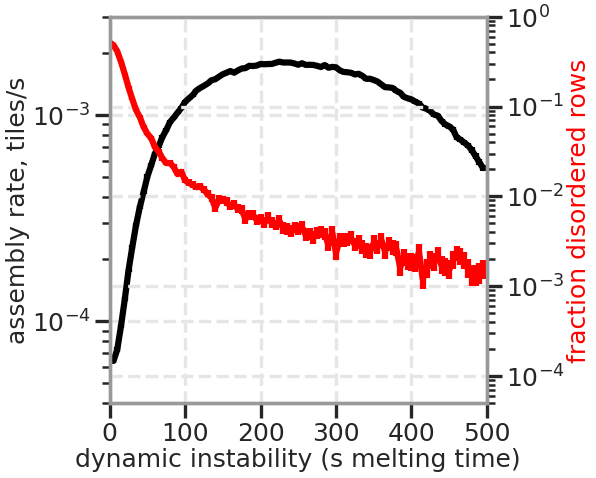

In [10]:
fig, ax = plt.subplots(figsize=(50/25.4,40/25.4), constrained_layout=True)
ax2 = ax.twinx()

r = "stall_error"
sm = sweep_melttime.get_node(f'/{r}/results_8.4')
cc = cci
ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black')
ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red')

# r = "stall_noerror"
# sm = sweep_melttime.get_node(f'/{r}/results_8.4')
# cc = calc_cols(sm)
# ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black', linestyle='dashed')
# ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red', linestyle='dashed')

# r = "mediumstall_error"
# sm = sweep_melttime.get_node(f'/{r}/results_8.4')
# cc = calc_cols(sm)
# ax.errorbar(sm.cols.melttime, cc['speed'], cc['speed_err'], color='black', linestyle='dotted')
# ax2.errorbar(sm.cols.melttime, cc['error_rate'], cc['error_rate_err'], color='red', linestyle='dotted')


ax.set_yscale('log')
ax.set_xlabel("dynamic instability (s melting time)")
ax.set_ylabel("assembly rate, tiles/s")
ax.set_ylim(4e-5, 3e-3)
ax.set_xlim(0, 500)

ax2.set_yscale('log')
ax2.set_ylabel('fraction disordered rows', color='red')
ax2.set_ylim(5e-5, 1.0)

fig.savefig("figure-plots/extfig4-instability-sweep.svg")



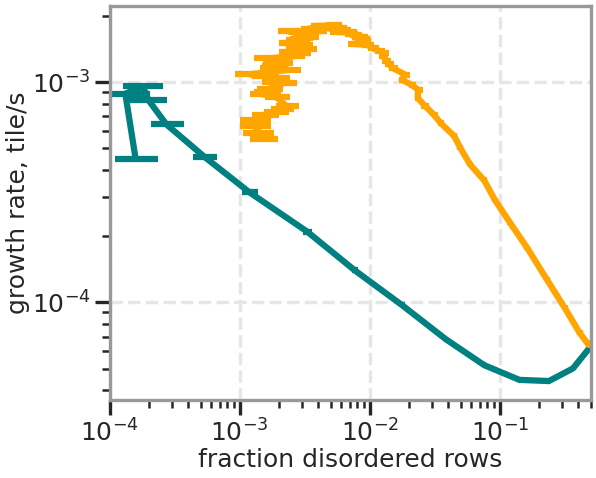

In [11]:
fig, ax = plt.subplots(figsize=(50/25.4,40/25.4), constrained_layout=True)

ax.errorbar(y=ccm['speed'], x=ccm['error_rate'], xerr=ccm['error_rate_err'], yerr=ccm['speed_err'], color='teal')

ax.errorbar(y=cci['speed'], x=cci['error_rate'], xerr=cci['error_rate_err'], yerr=cci['speed_err'], color='orange')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("fraction disordered rows")
ax.set_ylabel("growth rate, tile/s")
ax.set_xlim(1e-4, 5e-1)
fig.savefig("figure-plots/extfig4-errors-vs-speed.svg")